# 1. Importation des librairies et Data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import IsolationForest
import re


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


df_cleaned = pd.read_csv('dataset_cleaned_fr.csv', low_memory=False, delimiter=',')


pd.set_option('display.max_rows', None)

# 2. Analyse des données simple

### 2.1 Aperçus des données (Univariée)

In [6]:
df_cleaned.head()

,code,product_name,countries,ingredients_text,sugars_100g,nutrition_grade_fr,fat_100g,saturated-fat_100g,salt_100g,fiber_100g,proteins_100g,energy_100g,brands,additives_n,nutrition-score-fr_100g,carbohydrates_100g,pnns_groups_combined
0,36252,lion peanut x2,"france, us","milk chocolate coating (evaporated cane juice,...",38.1,E,20.000000,11.1,0.09652,2.5,2.50,1883.0,sunridge,1.0,16.0,70.000000,snacks sucrés
1,11747,triple belgian chocolaté chunk cookies,"uk,france",unknown,34.4,E,27.280193,11.1,0.85000,2.9,5.60,2184.0,marks & spencer,0.0,16.0,57.464646,snacks sucrés
2,25751,honey roast ham,"royaume-uni,france",porc d’origine britannique (élaboré avec 120 g...,2.9,C,2.000000,0.7,2.00000,0.1,18.38,564.0,"marks & spencer,m&s",1.0,8.0,4.300000,snacks sucrés
3,48569,barbecue sauce,"france, us",unknown,32.7,D,7.500000,0.8,1.28000,1.8,1.10,665.0,"mark and spencer, trader joe's",0.0,11.0,67.500000,graisses et sauces
4,80910,poulet tikka masala et riz pilaf,"uk,france",unknown,0.6,A,6.173091,1.6,0.63000,2.7,8.90,619.0,marks & spencer,0.0,12.0,13.857636,poissons viandes et œufs


In [21]:
df_cleaned.describe()

,code,sugars_100g,fat_100g,saturated-fat_100g,salt_100g,fiber_100g,proteins_100g,energy_100g,additives_n,nutrition-score-fr_100g,carbohydrates_100g
count,2.658000e+03,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000,2658.000000
mean,4.145938e+12,15.354864,13.732814,5.591448,0.656491,1.558790,6.556618,1223.595869,1.590105,11.587525,33.522593
std,2.822124e+12,17.646253,15.248695,7.014430,0.763053,2.187728,5.781698,792.256884,1.895131,7.145468,27.183892
min,1.169300e+04,-5.628879,-4.060164,-0.865828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38.750041
25%,3.046920e+12,2.800000,0.800000,0.300000,0.050800,0.000000,1.900000,435.000000,0.000000,7.000000,7.000000
50%,3.560070e+12,8.000000,8.100000,2.255000,0.349500,0.100000,5.900000,1351.500000,1.000000,11.000000,26.650000
75%,5.563001e+12,25.500000,24.000000,9.511846,1.016000,2.400000,8.900000,1895.750000,2.500000,16.000000,59.000000
max,5.449900e+13,78.250000,100.000000,31.000000,3.300000,9.212500,30.050000,3766.000000,8.500000,32.500000,100.356348


C:\Users\Amazi\AppData\Local\Temp\ipykernel_87276\2626680386.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pnns_groups_combined', y='sugars_100g', data=df_cleaned, palette='viridis')


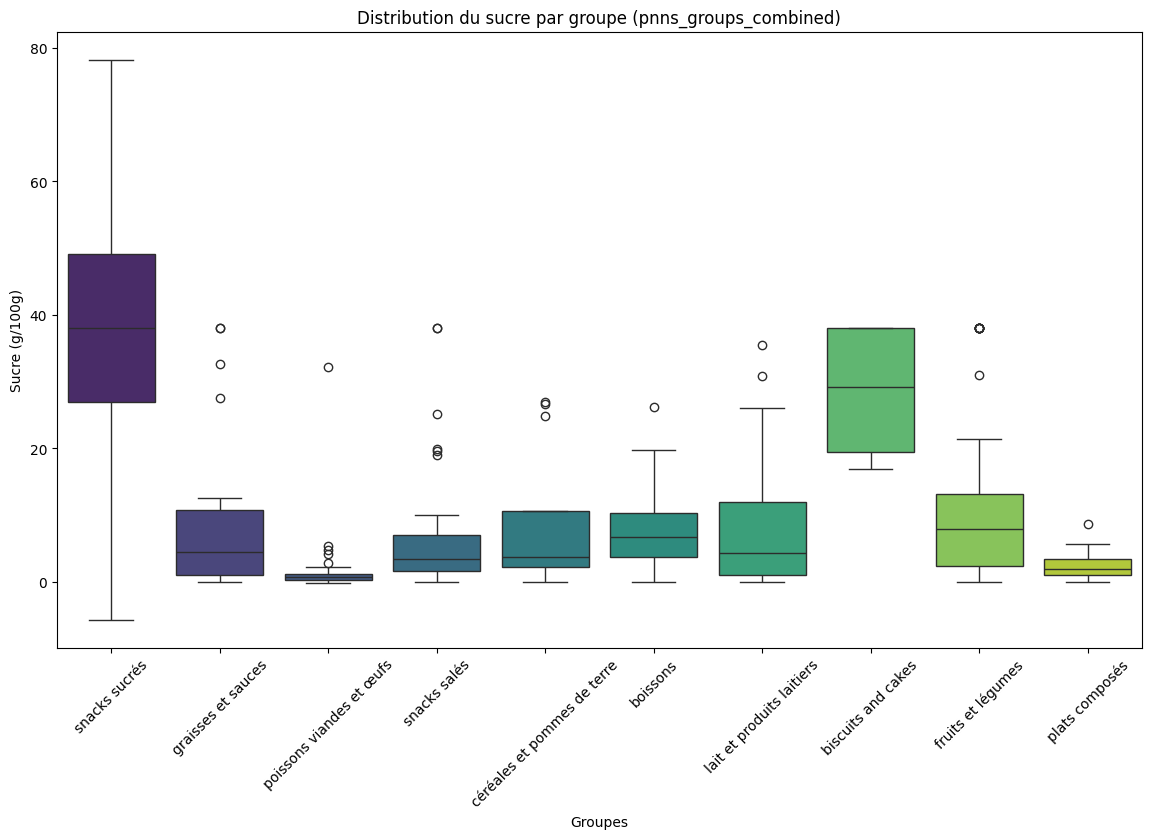

In [7]:
# Boxplot pour la distribution du sucre par groupe
plt.figure(figsize=(14, 8))
sns.boxplot(x='pnns_groups_combined', y='sugars_100g', data=df_cleaned, palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution du sucre par groupe (pnns_groups_combined)")
plt.xlabel("Groupes")
plt.ylabel("Sucre (g/100g)")
plt.show()

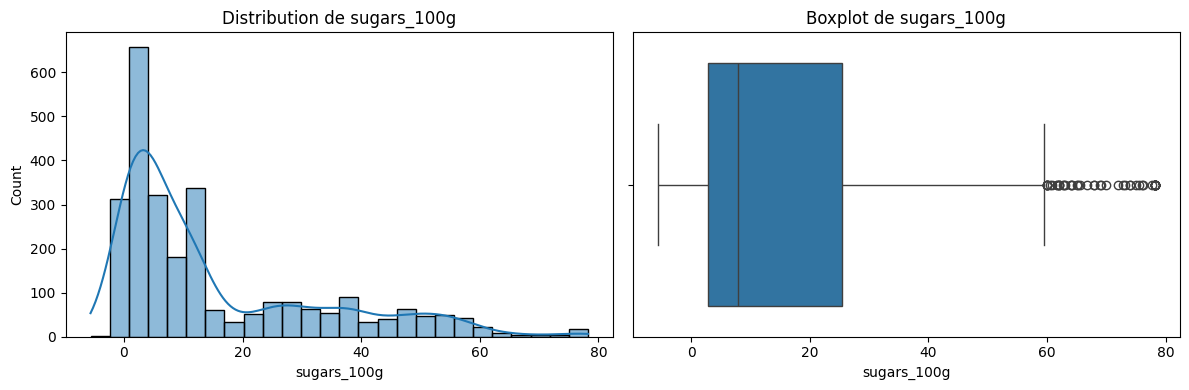

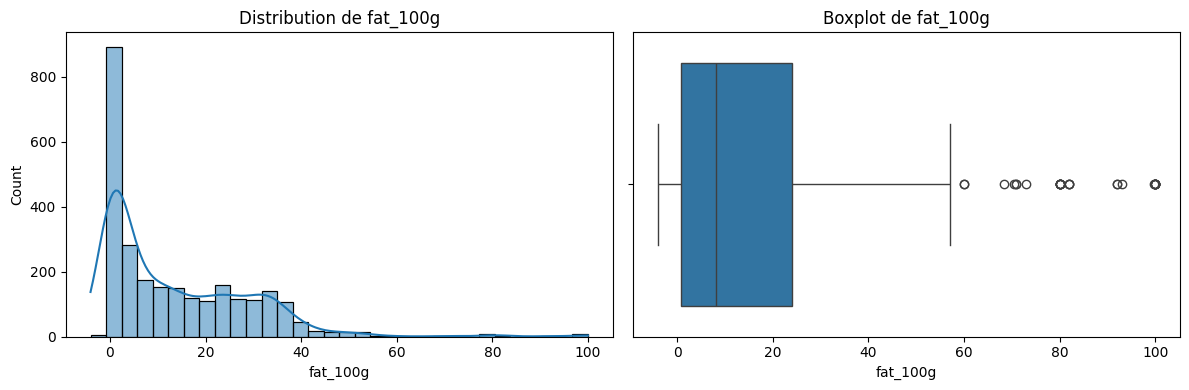

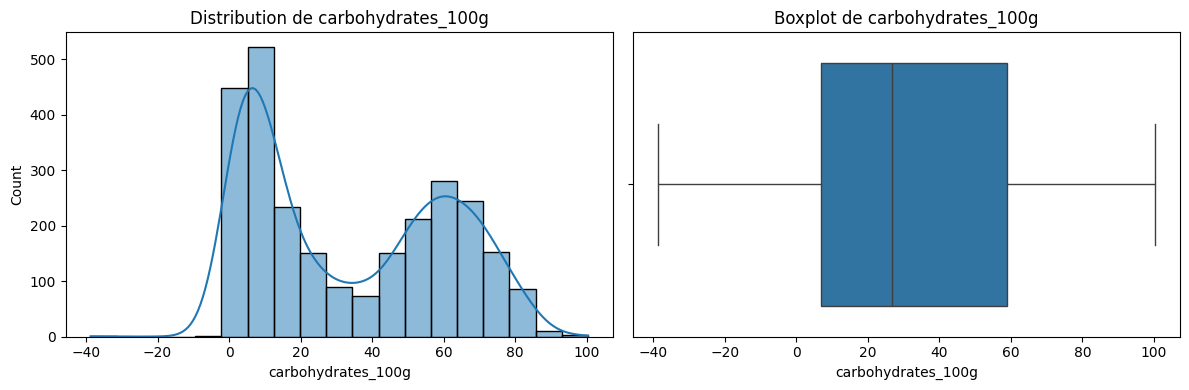

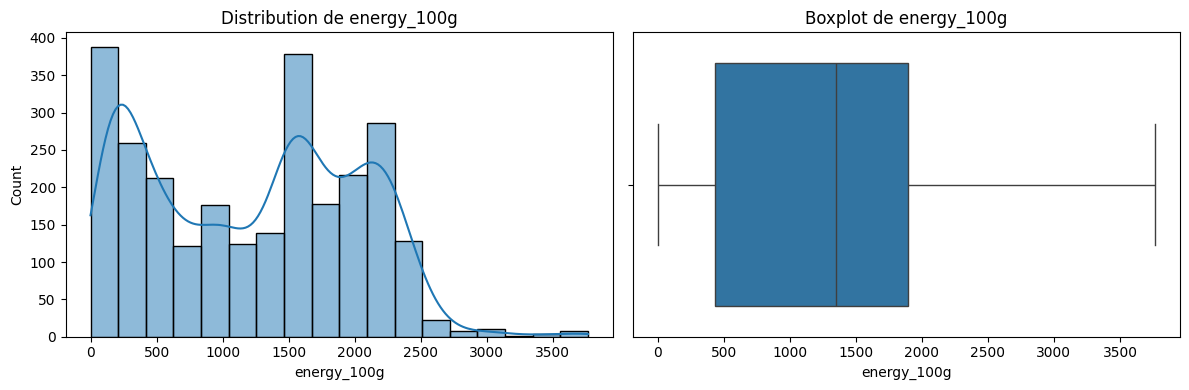

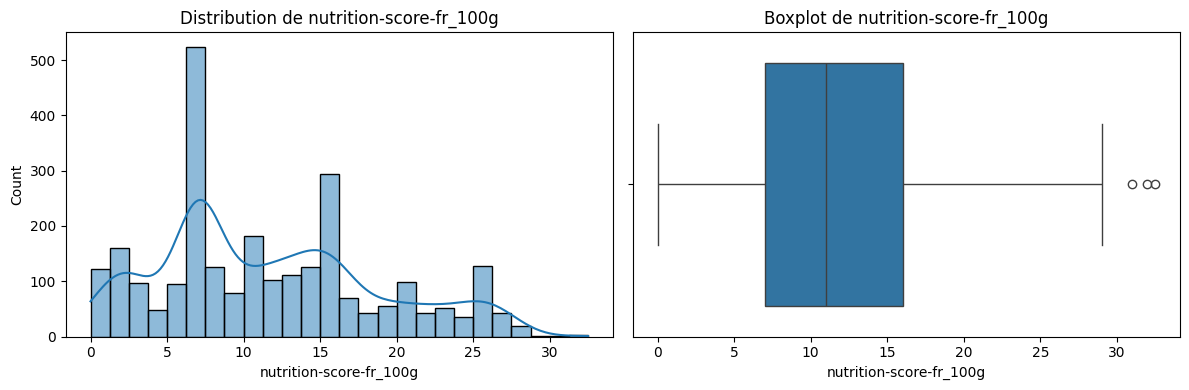

In [15]:
numerical_cols = ['sugars_100g', 'fat_100g', 'carbohydrates_100g',
                  'energy_100g', 'nutrition-score-fr_100g']

df_cleaned[numerical_cols].describe()

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_cleaned[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution de {col}')
    sns.boxplot(x=df_cleaned[col], ax=axes[1])
    axes[1].set_title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()

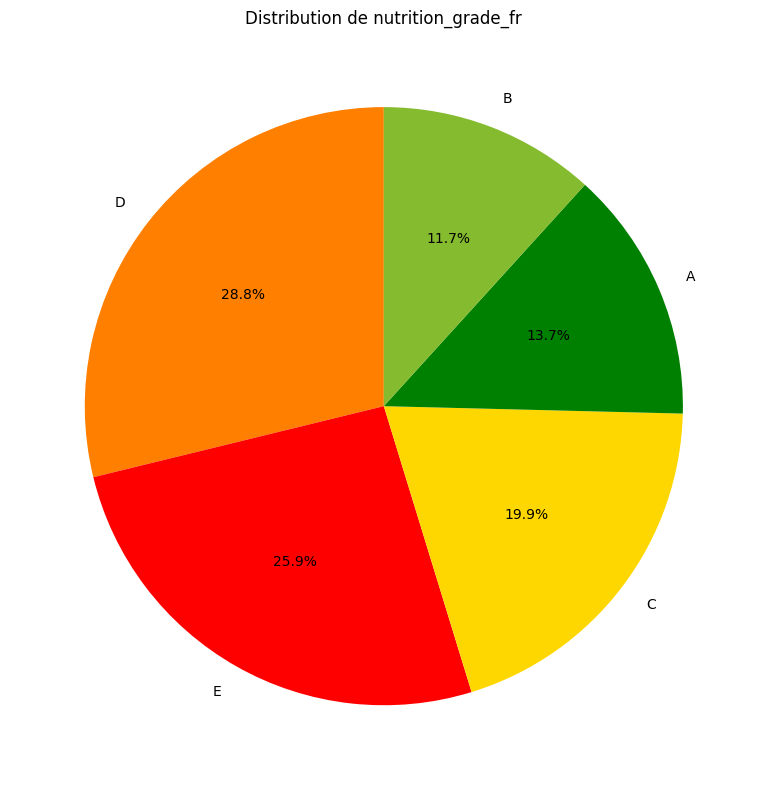

In [25]:

nutriscore_palette = {
    'A': '#008000',  # Vert
    'B': '#85BB2F',  # Vert clair
    'C': '#FFD700',  # Jaune
    'D': '#FF8000',  # Orange
    'E': '#FF0000'   # Rouge
}

categorical_cols = ['nutrition_grade_fr']

for col in categorical_cols:
    plt.figure(figsize=(8, 8))  
    
    
    values = df_cleaned[col].value_counts()
    colors = [nutriscore_palette[label] for label in values.index]
    

    plt.pie(
        values, 
        labels=values.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors
    )
    plt.title(f'Distribution de {col}')
    plt.ylabel('')  
    plt.tight_layout()
    plt.show()

- On observe une majorité de produit en Nutriscore D et E, Les Nutriscore A et B concerne un quart des données. 

- On est sur des données à priori assez riche en sucre.

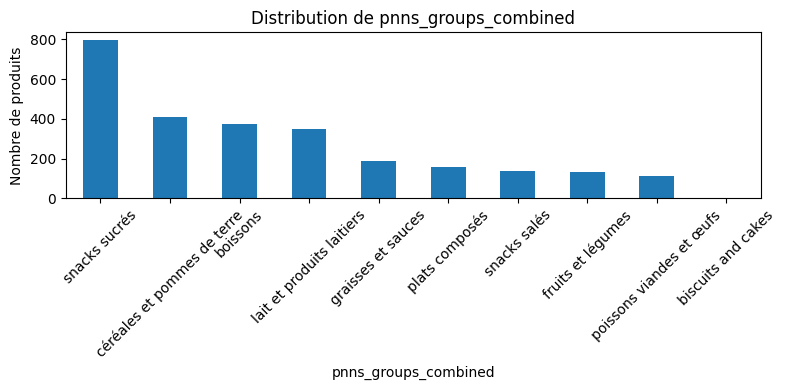

In [23]:
categorical_cols = ['pnns_groups_combined']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df_cleaned[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Nombre de produits')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 2.2 Analyse Bivariée

Repartition nutriscore par categorie de produits

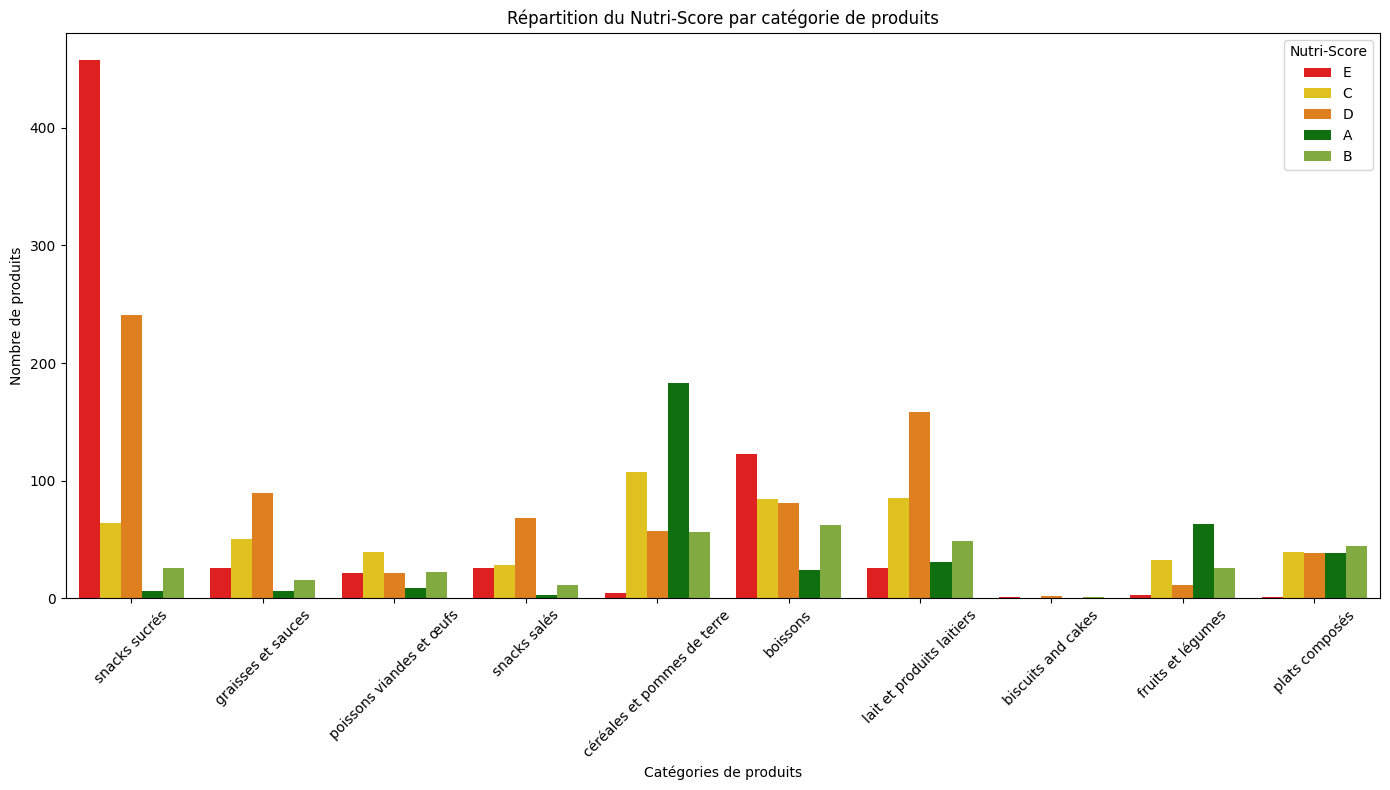

In [20]:
nutriscore_palette = {
    'A': '#008000',  # Vert
    'B': '#85BB2F',  # Vert clair
    'C': '#FFD700',  # Jaune
    'D': '#FF8000',  # Orange
    'E': '#FF0000'   # Rouge
}

plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_cleaned,
    x='pnns_groups_combined',
    hue='nutrition_grade_fr',
    palette=nutriscore_palette  
)
plt.xticks(rotation=45)
plt.title("Répartition du Nutri-Score par catégorie de produits")
plt.xlabel("Catégories de produits")
plt.ylabel("Nombre de produits")
plt.legend(title="Nutri-Score")
plt.tight_layout()
plt.show()

- Les snacks sucrés sont bien evdiddement les plus porteur de produit au nutriscore bas.

- La propention de produit de qualité la plus élévé est dans céréales et pommes de terre et fruits et légumes, les plats composé se défendent bien aussi (surement du au norme europènne strict).

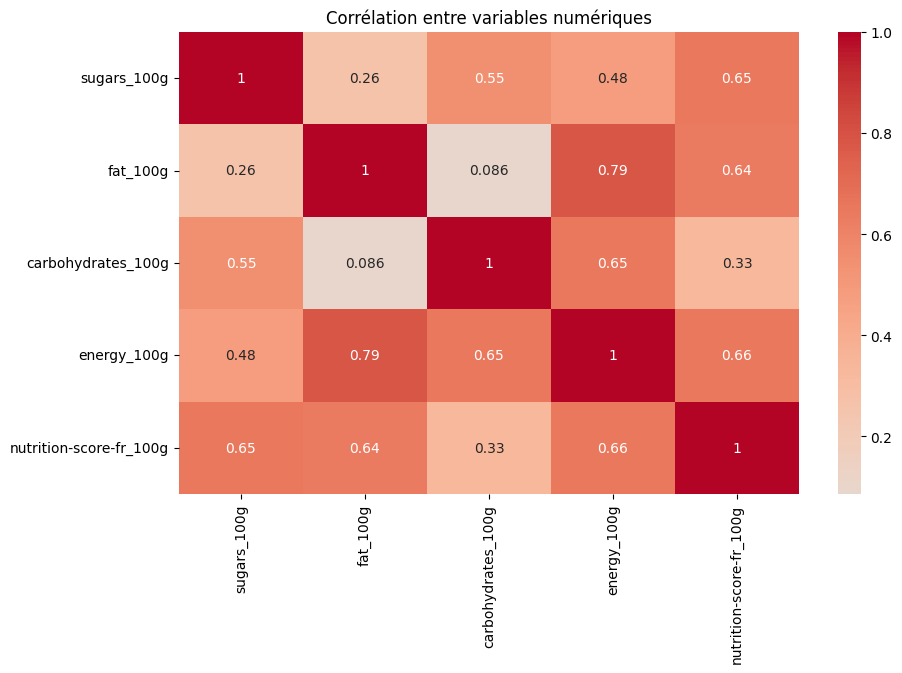

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation entre variables numériques")
plt.show()

- Le sucre (sugars_100g) est assez fortement corrélé au Nutri-Score (0.65). Plus un produit est sucré, plus son score nutritionnel est mauvais. logique et ça confirme que le sucre est un bon indicateur de qualité nutritionnelle. Ça renforce l’idée de mon appli.

- sugars_100g est aussi corrélé aux glucides totaux (carbohydrates_100g) à 0.55. Tous les sucres sont des glucides, mais pas l’inverse. Donc un produit peut être riche en glucides sans forcément être sucré. utile de différencier les bons et mauvais glucides.

- Le sucre est aussi lié à l’énergie (energy_100g) à 0.48, et les glucides encore plus (0.65). Les produits sucrés sont souvent aussi caloriques. Je pourrais combiner sucre + énergie dans l’analyse ou les alertes de l’appli.


Repartition du sucre par Nutriscore

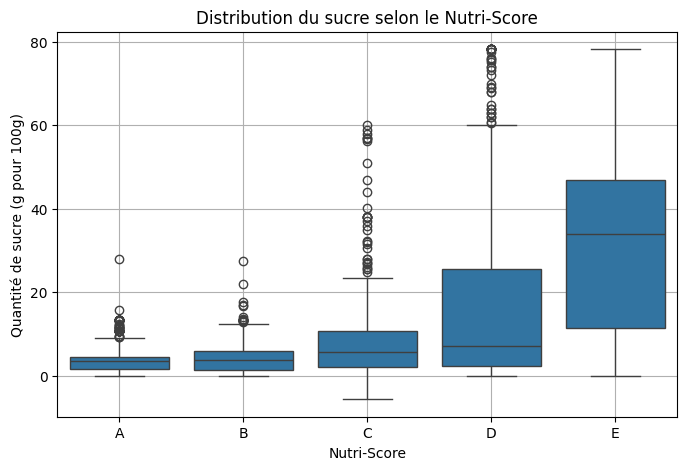

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x='nutrition_grade_fr', y='sugars_100g', order=['A', 'B', 'C', 'D', 'E'])
plt.title("Distribution du sucre selon le Nutri-Score")
plt.xlabel("Nutri-Score")
plt.ylabel("Quantité de sucre (g pour 100g)")
plt.grid(True)
plt.show()

- Cela est la confirmation de la corrélation entre le sucre et le Nutriscore. 

- Cartaines valeurs font exceptions mais ne sont pas forcement abbérrantes.

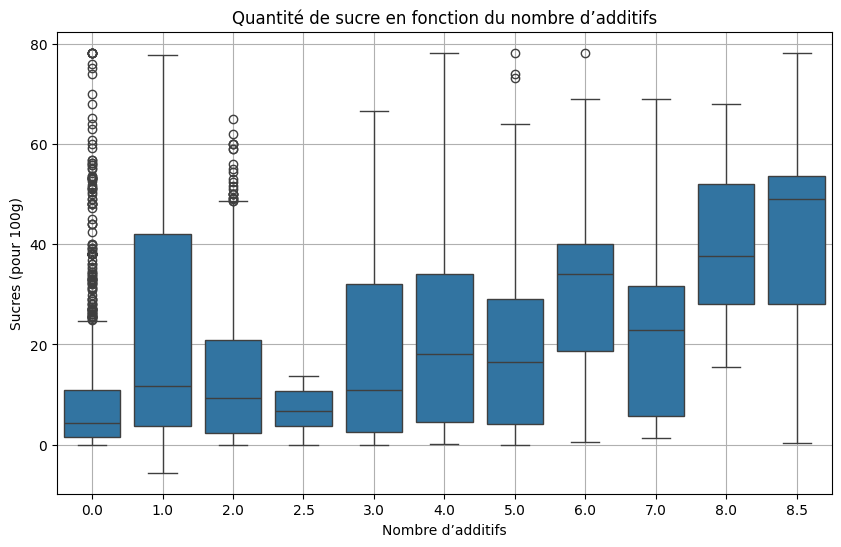

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='additives_n', y='sugars_100g')
plt.title('Quantité de sucre en fonction du nombre d’additifs')
plt.xlabel('Nombre d’additifs')
plt.ylabel('Sucres (pour 100g)')
plt.grid(True)
plt.show()

- Attention je remarque une coquille dans le nettoyage un additif est soit dand un produit soit pas (pas a moitier) 2.5 et 8.5 sont des valeurs aberrantes.

- J’ai voulu voir si les produits plus transformés (avec plus d’additifs) sont aussi plus sucrés.

- On vois une relative tendance haussière du taux de sucre en fonction des additifs. plus le nombre d’additifs augmente, plus la médiane de sucre tend à être élevée. Ça confirme l’idée que les produits ultra-transformés sont souvent plus sucrés. 


Repartition des produit par score de sucre

In [38]:
median_sugar_by_category = df_cleaned.groupby('pnns_groups_combined')['sugars_100g'].median()

df_cleaned['median_sugar_category'] = df_cleaned['pnns_groups_combined'].map(median_sugar_by_category)

df_cleaned['sugar_ratio'] = df_cleaned['sugars_100g'] / df_cleaned['median_sugar_category']


def sugar_score(row):
    if pd.isna(row['sugar_ratio']):
        return None
    if row['sugar_ratio'] < 0.5:
        return 1
    elif row['sugar_ratio'] < 0.9:
        return 2
    elif row['sugar_ratio'] <= 1.1:
        return 3
    elif row['sugar_ratio'] <= 1.5:
        return 4
    else:
        return 5

df_cleaned['sugar_score'] = df_cleaned.apply(sugar_score, axis=1)

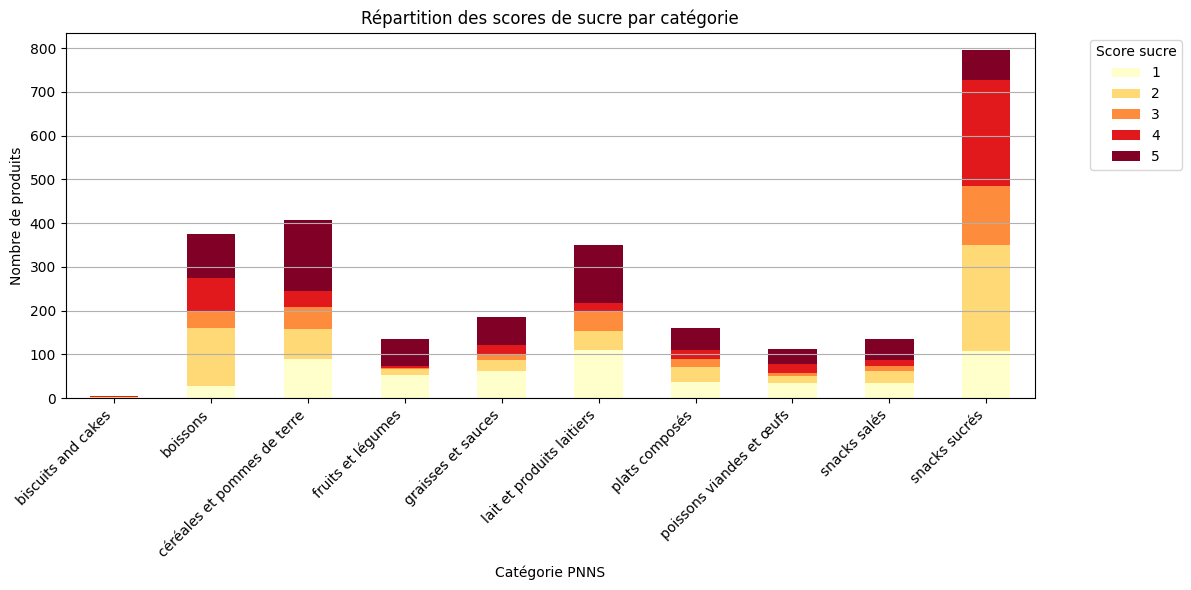

In [41]:

sugar_score_by_category = df_cleaned.pivot_table(
    index='pnns_groups_combined',
    columns='sugar_score',
    aggfunc='size',
    fill_value=0
)


import matplotlib.pyplot as plt

sugar_score_by_category.plot(
    kind='bar',
    stacked=True,
    colormap='YlOrRd',
    figsize=(12, 6)
)

plt.title('Répartition des scores de sucre par catégorie')
plt.xlabel('Catégorie PNNS')
plt.ylabel('Nombre de produits')
plt.legend(title='Score sucre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

- Sur ce graphique en barres empilées, chaque barre représente une catégorie d'aliments (catégories PNNS). À l'intérieur de chaque barre, les différentes couleurs montrent la répartition des scores de sucre (de 0 à 5 en fonction de l'eloignement du produit a la médiane de la catégorie), ce qui permet de voir combien de produits ont chaque score.

# 3. Analyse de Données Multivariées

## Analyse En Composantes Principales (ACP)

C:\Users\Amazi\AppData\Local\Temp\ipykernel_87276\3535227786.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'F{i+1}' for i in range(len(explained_var))], y=explained_var, palette='rocket')


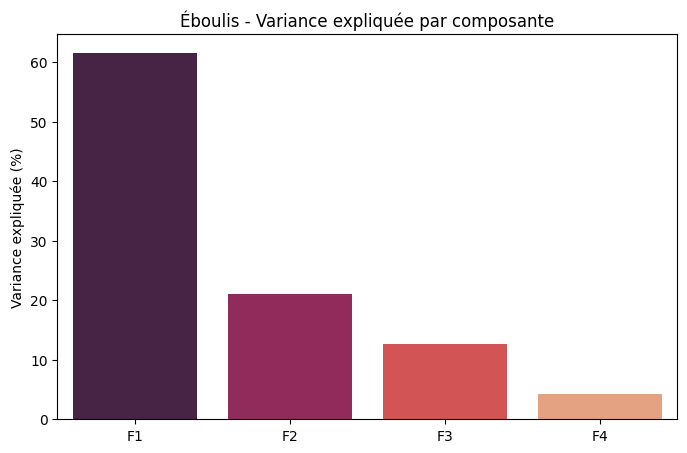

In [ ]:
# Sélection des colonnes 
features = [numerical_cols]
X = df_cleaned[numerical_cols]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Éboulis : variance expliquée
plt.figure(figsize=(8, 5))
explained_var = pca.explained_variance_ratio_ * 100
sns.barplot(x=[f'F{i+1}' for i in range(len(explained_var))], y=explained_var, palette='rocket')
plt.ylabel("Variance expliquée (%)")
plt.title("Éboulis - Variance expliquée par composante")
plt.show()

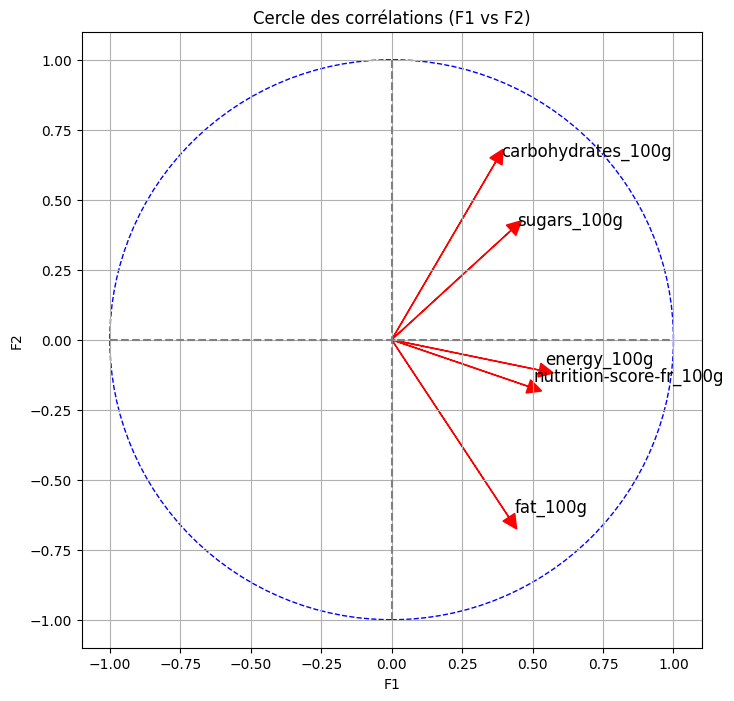

In [48]:

pca_components = pca.components_
plt.figure(figsize=(8, 8))
for i, var in enumerate(numerical_cols):
    plt.arrow(0, 0, pca_components[0, i], pca_components[1, i],
              head_width=0.05, head_length=0.05, fc='red', ec='red')
    plt.text(pca_components[0, i] + 0.02, pca_components[1, i] + 0.02, var, fontsize=12)

plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b', linestyle='--')
plt.gca().add_patch(circle)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Cercle des corrélations (F1 vs F2)')
plt.grid()
plt.show()

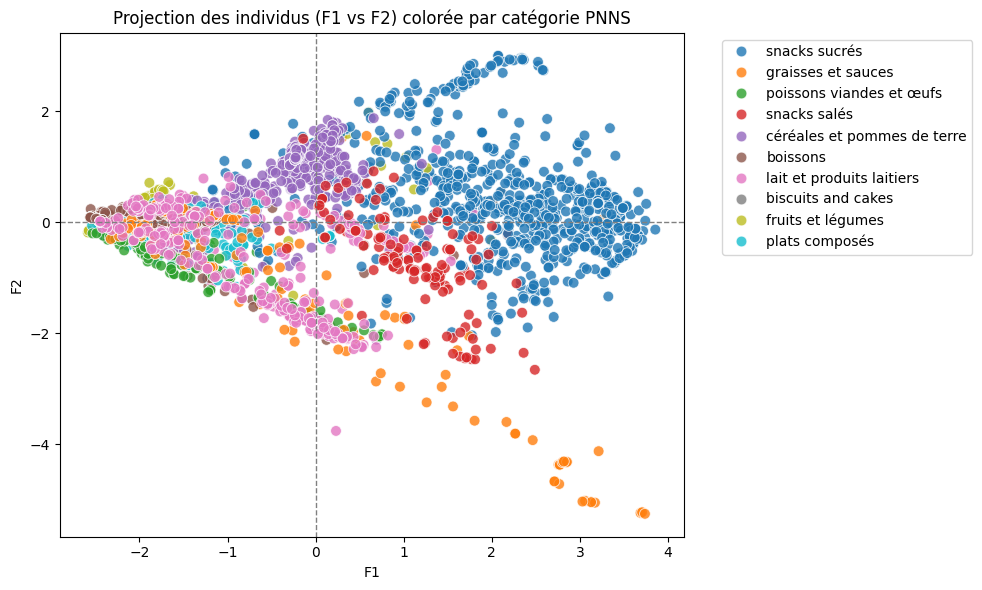

In [51]:
# Construction d'un DataFrame PCA
df_pca = pd.DataFrame(X_pca, columns=['F1', 'F2', 'F3', 'F4'])
df_pca['pnns_group'] = df_cleaned.loc[X.index, 'pnns_groups_combined']
df_pca['nutriscore'] = df_cleaned.loc[X.index, 'nutrition-score-fr_100g']

# Affichage de la projection selon F1 et F2, coloré par groupe PNNS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='F1', y='F2', hue='pnns_group', palette='tab10', s=60, alpha=0.8)
plt.title("Projection des individus (F1 vs F2) colorée par catégorie PNNS")
plt.axhline(0, color='gray', lw=1, ls='--')
plt.axvline(0, color='gray', lw=1, ls='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()